In [1]:
import torch

print(f"🔥 PyTorch версия: {torch.__version__}")
print(f"🚀 CUDA доступна: {torch.cuda.is_available()}")
print(f"🎮 Название GPU: {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "❌ Нет доступного GPU")

🔥 PyTorch версия: 2.5.1+cu121
🚀 CUDA доступна: True
🎮 Название GPU: NVIDIA GeForce RTX 4080 Laptop GPU


In [2]:
from bert_crf_utills import (
    prepare_data, BERT_CRF, train_model, evaluate_model
)
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import os

d:\dev\vitte\pii_detecting_and_masking_model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_path = "bert_crf_model.pth"
nerus_path = "nerus_lenta.conllu"
tokenizer_name="bert-base-multilingual-cased"
max_samples=2000
max_len=32
batch_size=8
num_epochs=3
lr=3e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

train_dataset, test_dataset, _, _ = prepare_data(
    nerus_path, tokenizer, max_samples=max_samples, max_len=max_len
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    tag2id = checkpoint['tag2id']
    id2tag = checkpoint['id2tag']
    
    model = BERT_CRF(tokenizer_name, num_labels=len(tag2id)).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Модель загружена: {model_path}")
else:
    print(f"❌ Модель не найдена: {model_path}")
    exit(1)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

train_losses = []

for epoch in range(1, num_epochs + 1):
    avg_loss = train_model(model, train_loader, optimizer, device)

    train_losses.append(avg_loss)

    print(f"Epoch {epoch}/{num_epochs}: Loss = {avg_loss:.4f}")

# Оценка
evaluate_model(model, test_loader, device, id2tag)

C:\Users\Istari\AppData\Local\Temp\ipykernel_22320\2907284892.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Модель загружена: bert_crf_model.pth
Epoch 1/3: Loss = 60.7520
Epoch 2/3: Loss = 4.4757
Epoch 3/3: Loss = 2.6472

Classification Report:
              precision    recall  f1-score   support

         LOC       0.98      0.97      0.97       306
         ORG       0.97      0.97      0.97       827
         PER       0.98      0.98      0.98       339

   micro avg       0.98      0.97      0.97      1472
   macro avg       0.98      0.97      0.97      1472
weighted avg       0.98      0.97      0.97      1472



In [ ]:
# Сохранение модели в файл
torch.save({
    'model_state_dict': model.state_dict(),
    'tag2id': tag2id,
    'id2tag': id2tag
}, "bert_crf_model.pth")

print("Модель сохранена в bert_crf_model.pth")


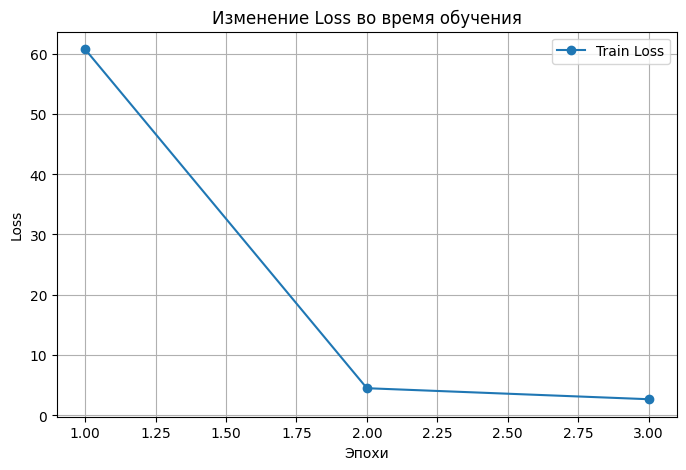

In [6]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.title("Изменение Loss во время обучения")
plt.legend()
plt.grid()
plt.show()
